In [217]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [218]:
connect_db = sqlite3.connect('../data/checking-logs-test-control.sqlite')
query = '''
        select uid, labname, numTrials, timestamp from checker where uid like 'user_%' and status = 'ready'
        '''
df = pd.io.sql.read_sql(query, connect_db, parse_dates=['timestamp'])
df.head()

,uid,labname,numTrials,timestamp
0,user_4,project1,1,2020-04-17 05:19:02.744528
1,user_4,project1,2,2020-04-17 05:22:45.549397
2,user_4,project1,3,2020-04-17 05:34:24.422370
3,user_4,project1,4,2020-04-17 05:43:27.773992
4,user_4,project1,5,2020-04-17 05:46:32.275104


In [219]:
# uid, labname, numTrials, hour, day-ofweek,
df['hour'] = df.timestamp.dt.hour
df['day-ofweek'] = df.timestamp.dt.dayofweek
df.drop('timestamp', inplace=True, axis=1)
df

,uid,labname,numTrials,hour,day-ofweek
0,user_4,project1,1,5,4
1,user_4,project1,2,5,4
2,user_4,project1,3,5,4
3,user_4,project1,4,5,4
4,user_4,project1,5,5,4
...,...,...,...,...,...
1681,user_19,laba06s,9,20,3
1682,user_1,laba06s,6,20,3
1683,user_1,laba06s,7,20,3
1684,user_1,laba06s,8,20,3


In [220]:
df = pd.get_dummies(df, prefix=['uid', 'labname'], columns=['uid', 'labname'])
df

,numTrials,hour,day-ofweek,uid_user_0,uid_user_1,uid_user_10,uid_user_11,uid_user_12,uid_user_13,uid_user_14,uid_user_15,uid_user_16,uid_user_17,uid_user_18,uid_user_19,uid_user_2,uid_user_20,uid_user_21,uid_user_22,uid_user_23,uid_user_24,uid_user_25,uid_user_26,uid_user_27,uid_user_28,uid_user_29,uid_user_3,uid_user_30,uid_user_31,uid_user_4,uid_user_6,uid_user_7,uid_user_8,labname_code_rvw,labname_lab02,labname_lab03,labname_lab03s,labname_lab05s,labname_laba04,labname_laba04s,labname_laba05,labname_laba06,labname_laba06s,labname_project1
0,1,5,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,2,5,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,3,5,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,4,5,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,5,5,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1681,9,20,3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1682,6,20,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1683,7,20,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1684,8,20,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [221]:
scaler = StandardScaler()
df[['numTrials', 'hour']] = scaler.fit_transform(df[['numTrials', 'hour']])
df

,numTrials,hour,day-ofweek,uid_user_0,uid_user_1,uid_user_10,uid_user_11,uid_user_12,uid_user_13,uid_user_14,uid_user_15,uid_user_16,uid_user_17,uid_user_18,uid_user_19,uid_user_2,uid_user_20,uid_user_21,uid_user_22,uid_user_23,uid_user_24,uid_user_25,uid_user_26,uid_user_27,uid_user_28,uid_user_29,uid_user_3,uid_user_30,uid_user_31,uid_user_4,uid_user_6,uid_user_7,uid_user_8,labname_code_rvw,labname_lab02,labname_lab03,labname_lab03s,labname_lab05s,labname_laba04,labname_laba04s,labname_laba05,labname_laba06,labname_laba06s,labname_project1
0,-0.788667,-2.562352,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,-0.756764,-2.562352,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,-0.724861,-2.562352,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,-0.692958,-2.562352,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,-0.661055,-2.562352,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1681,-0.533442,0.945382,3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1682,-0.629151,0.945382,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1683,-0.597248,0.945382,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1684,-0.565345,0.945382,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [222]:
df.to_csv('..data/dayofweek.csv', index=False)

In [223]:
X = df.drop('day-ofweek', axis=1)
y = df['day-ofweek']
y_pred_naive = np.array([np.argmax(np.bincount(y))] * len(y))
accuracy_score(y, y_pred_naive)

0.23487544483985764

In [224]:
logis_reg_model = LogisticRegression(random_state=21, fit_intercept=False)
logis_reg_model.fit(X, y)
pred = logis_reg_maodel.predict(X)
accuracy_score(y, pred)

0.6405693950177936

In [225]:
def calc_coefs(coefs, features, n=10):
    fig, ax = plt.subplots(figsize=(15, 8))
    coefs /= coefs.sum()
    indices = coefs.argsort()[::-1][:n]
    ax.barh(np.arange(n), coefs[indices], color='green')
    ax.set_yticks(np.arange(n))
    ax.set_yticklabels(features[indices])
    ax.invert_yaxis()
    plt.show()

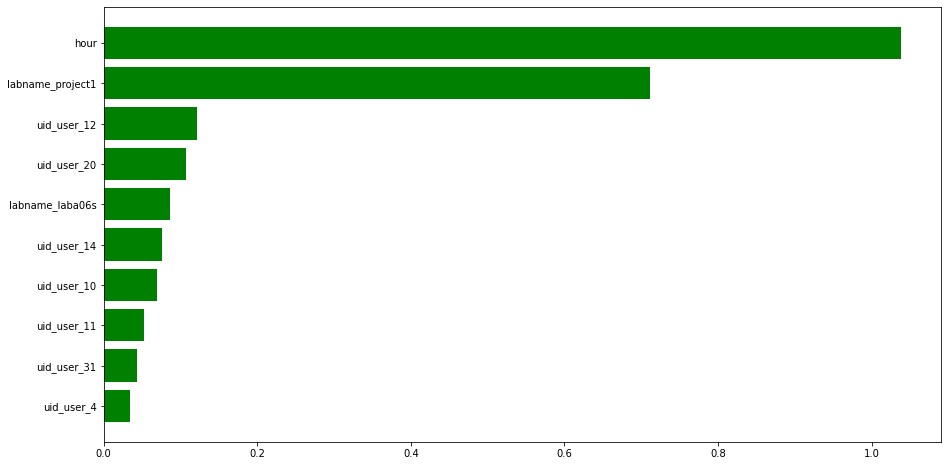

In [226]:
calc_coefs(logis_reg_model.coef_.mean(axis=0), X.columns)

In [227]:
svc = SVC(probability=True, random_state=21)
param_grid = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
gs = GridSearchCV(svc, param_grid, scoring='accuracy')
gs.fit(X, y)
gs.best_params_

{'kernel': 'poly'}

In [228]:
y_pred = gs.predict(X)
accuracy_score(y, y_pred)

0.8594306049822064

In [229]:
svc = SVC(probability=True, kernel = 'linear', random_state=21)
svc.fit(X, y)

SVC(kernel='linear', probability=True, random_state=21)

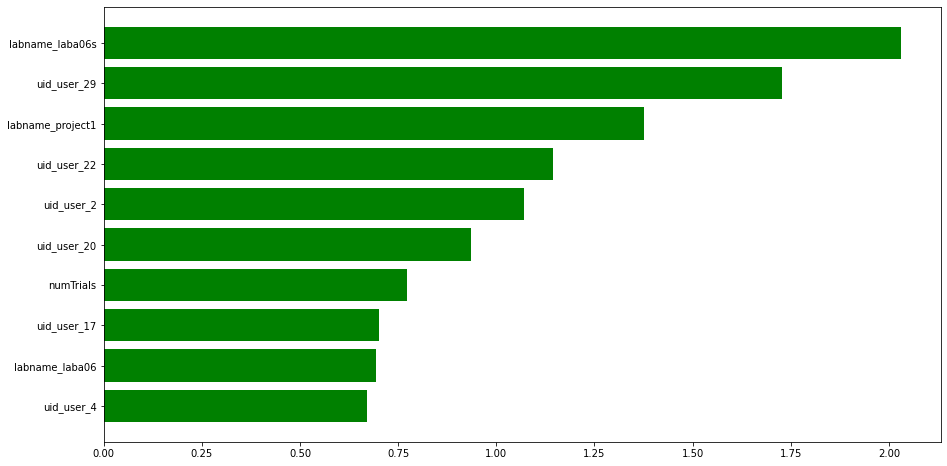

In [230]:
calc_coefs(svc.coef_.mean(axis=0), X.columns)

In [231]:
Dec_tree_class = DecisionTreeClassifier(random_state=21)
param_grid = {'max_depth': [3, 5, 7, 10, 14, 16, 18, 20]}
gs = GridSearchCV(Dec_tree_class, param_grid, scoring='accuracy', n_jobs=-1)
gs.fit(X, y)
gs.best_params_

{'max_depth': 16}

In [232]:
y_pred = gs.predict(X)
accuracy_score(y, y_pred)

0.9608540925266904

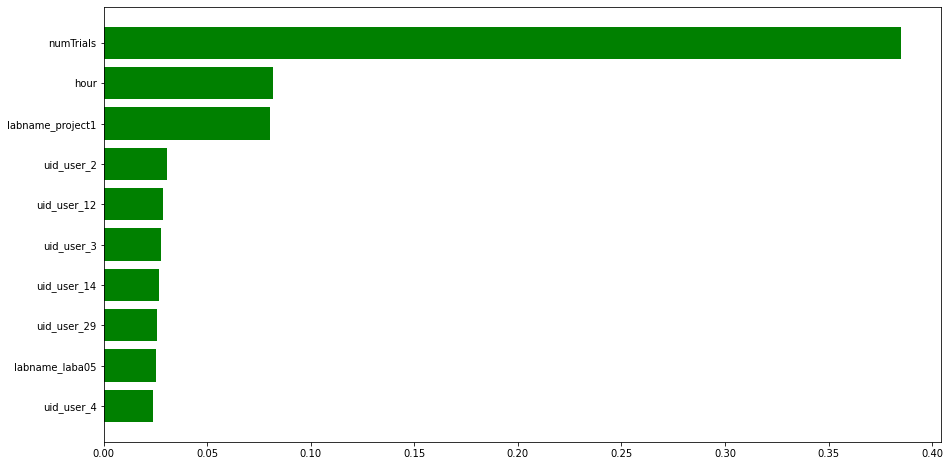

In [233]:
calc_coefs(gs.best_estimator_.feature_importances_, X.columns)

In [234]:
random_forest_model = RandomForestClassifier(random_state=21)
param_grid = {'n_estimators': [50, 100, 200, 300],
              'max_depth': [5, 7, 10, 13, 15]}
gs = GridSearchCV(random_forest_model, param_grid, scoring='accuracy', n_jobs=-1)
gs.fit(X, y)
gs.best_params_

{'max_depth': 13, 'n_estimators': 50}

In [235]:
y_pred = gs.predict(X)
accuracy_score(y, y_pred)

0.9472123368920522

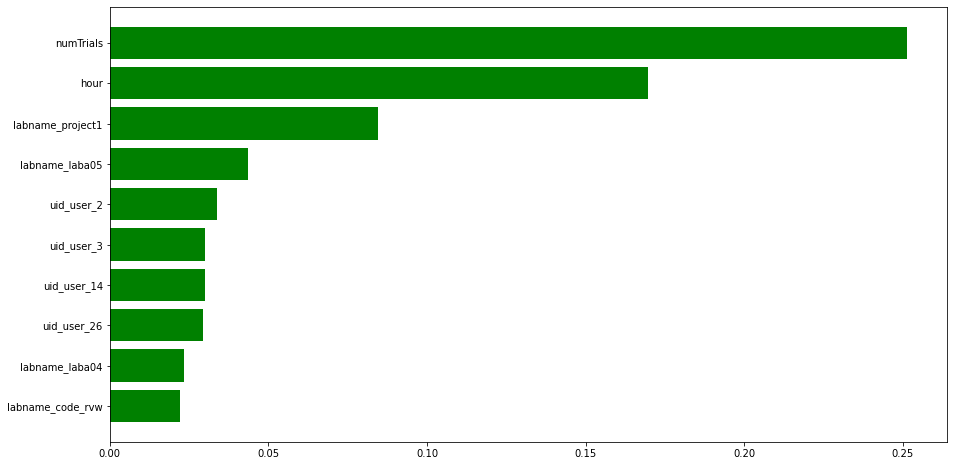

In [236]:
calc_coefs(gs.best_estimator_.feature_importances_, X.columns)